In [8]:
#importing important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from skmultilearn.model_selection import iterative_train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss,f1_score,confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelEncoder

In [2]:
import tensorflow as tf



In [6]:
tf.version

AttributeError: module 'tensorflow' has no attribute 'version'

In [10]:
import h5py

h5py.__version__


'3.1.0'

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import random
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(seed=42)

In [6]:
#reading train dataset

train_features=pd.read_csv('../input/lish-moa/train_features.csv')
test_features=pd.read_csv('../input/lish-moa/test_features.csv')
train_targets_scored=pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored=pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
train_drug=pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
#list of names of the MoAs in the dataset
target_cols_scored=[col for col in train_targets_scored.columns if col not in ['sig_id']]
target_cols_nonscored=[col for col in train_targets_nonscored.columns if col not in ['sig_id']]

In [8]:
#separating gene feautres and cell features in a separate list
#we know that all the gene expression features name starts with 'g-' and cell features name starts with 'c-', hence trying to observe set of all the gene expression as one function and all the cell functions as one features
gene_features=[]
cell_features=[]
for i in train_features.columns:
    if i.startswith('g-'):
        gene_features.append(i)
    if i.startswith('c-'):
        cell_features.append(i)

In [9]:
#merging the train dataset and train target scored dataset into one
train_merge=pd.merge(train_features,train_targets_scored,on="sig_id",how="left")

In [10]:
train_merge=train_merge[train_merge['cp_type']!='ctl_vehicle']
#test_features1=test_features.copy()
test_features1=test_features[test_features['cp_type']!='ctl_vehicle']

In [11]:
train_merge.drop(columns=['cp_type'],inplace=True)
test_features1.drop(columns=['cp_type'],inplace=True)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import *

In [13]:
from sklearn.decomposition import PCA

def PCA_decomposition(train,valid,test,n_comp_gene,n_comp_cell,seed):
     '''
    function is used to generate pca components of gene and cell features of train, validationa and test set
    Args:
        train:train dataset
        valid:validation dataset
        test:test dataset
        n_comp_gene: number of PCA components for gene features
        n_comp_cell: number of PCA components for cell features
        
    Returns:
    
        train:train dataset with concatenation of pca generated features
        valid:validation dataset with concatenation of pca generated features
        test:test dataset with concatenation of pca generated features
        
    '''
    pca_gene_feat=[f'pca_gene_{col}' for col in range(n_comp_gene)]
    pca_cell_feat=[f'pca_cell_{col}' for col in range(n_comp_cell)]
    pca_gene=PCA(n_components=n_comp_gene,random_state=seed)
    X_train_pca_gene=pd.DataFrame(pca_gene.fit_transform(train[gene_features]),columns=pca_gene_feat).reset_index(drop=True)
    X_valid_pca_gene=pd.DataFrame(pca_gene.transform(valid[gene_features]), columns=pca_gene_feat).reset_index(drop=True)
    X_test_pca_gene=pd.DataFrame(pca_gene.transform(test[gene_features]), columns=pca_gene_feat).reset_index(drop=True)

    pca_cell=PCA(n_components=n_comp_cell,random_state=seed)
    X_train_pca_cell=pd.DataFrame(pca_cell.fit_transform(train[cell_features]), columns=pca_cell_feat).reset_index(drop=True)
    X_valid_pca_cell=pd.DataFrame(pca_cell.transform(valid[cell_features]), columns=pca_cell_feat).reset_index(drop=True)
    X_test_pca_cell=pd.DataFrame(pca_cell.transform(test[cell_features]), columns=pca_cell_feat).reset_index(drop=True)
    
    train=pd.concat([train.reset_index(drop=True),X_train_pca_gene,X_train_pca_cell],axis=1)
    valid=pd.concat([valid.reset_index(drop=True),X_valid_pca_gene,X_valid_pca_cell],axis=1)
    test=pd.concat([test.reset_index(drop=True),X_test_pca_gene,X_test_pca_cell],axis=1)
    return train,valid,test

In [14]:
from sklearn.preprocessing import QuantileTransformer
def quantile_scaling(train,valid,test):
    
       '''
       takes in input, valid, test for quantile transformation
       Args:
            train:train dataset
            valid:validation dataset
            test:test dataset
       Returns:
            train: transformed train dataset
            valid: transformed validation dataset
            test:  transformed test dataset
        
        '''
        
       qt=QuantileTransformer(output_distribution='normal')
       train=qt.fit_transform(train)
       valid=qt.transform(valid)
       test=qt.transform(test)
       return train,valid,test

In [15]:
lb=LabelEncoder()
lb.fit(train_merge['cp_time'])

train_merge['cp_time']=lb.transform(train_merge['cp_time'])
test_features1['cp_time']=lb.transform(test_features1['cp_time'])
##################################################################################
lb1=LabelEncoder()
lb1.fit(train_merge['cp_dose'])

train_merge['cp_dose']=lb1.transform(train_merge['cp_dose'])
test_features1['cp_dose']=lb1.transform(test_features1['cp_dose'])

In [16]:
feature_groups=gene_features+cell_features+['cp_time','cp_dose']

In [17]:
train_dataset=train_merge[feature_groups]


In [18]:
test_dataset=test_features1[feature_groups]


In [19]:
Y=train_merge[target_cols_scored]


In [20]:
#define frequency table
def f_table(list1):
    table_dic={}
    for i in list1:
        if i not in table_dic.keys():
            table_dic[i]=1
        else:
            table_dic[i]+=1
    return table_dic

In [21]:
from copy import deepcopy as dp


In [22]:
tar_freq = np.array([np.min(list(f_table(train_merge[target_cols_scored].iloc[:,i]).values())) for i in range(len(target_cols_scored))])
tar_weight0 = np.array([np.log(i+100) for i in tar_freq])
tar_weight0_min = dp(np.min(tar_weight0))
tar_weight = tar_weight0_min/tar_weight0

In [23]:
import tensorflow_addons as tfa


In [24]:
from tensorflow.keras import backend
def logloss(y_true, y_pred):
    #y_pred = tf.clip_by_value(y_pred,0.001,0.999)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [25]:
n_folds=10
SEEDS=[660,42,2020,72,64]
def inference():
    
    '''
    The function is responsible for taking a weighted average prediction of the output of the four models.
    
    '''
    
    y_pred_model1_seed_level=np.zeros((len(test_dataset),206))
    oof_model1_seed_level=np.zeros((len(train_dataset),206))
    
    y_pred_model2_seed_level=np.zeros((len(test_dataset),206))
    oof_model2_seed_level=np.zeros((len(train_dataset),206))
    
    y_pred_model3_seed_level=np.zeros((len(test_dataset),206))
    oof_model3_seed_level=np.zeros((len(train_dataset),206))
    
    y_pred_model4_seed_level=np.zeros((len(test_dataset),206))
    oof_model4_seed_level=np.zeros((len(train_dataset),206))
    
    
    for seed in SEEDS:
        seed_everything(seed)
        y_pred_model1=np.zeros((len(test_dataset),206))
        oof_model1=np.zeros((len(train_dataset),206))
        
        y_pred_model2=np.zeros((len(test_dataset),206))
        oof_model2=np.zeros((len(train_dataset),206))
        
        y_pred_model3=np.zeros((len(test_dataset),206))
        oof_model3=np.zeros((len(train_dataset),206))
        
        y_pred_model4=np.zeros((len(test_dataset),206))
        oof_model4=np.zeros((len(train_dataset),206))
        fold=0
        mskf = MultilabelStratifiedKFold(n_splits=n_folds,shuffle=True,random_state=seed)
        for train_idx, test_idx in mskf.split(train_dataset,Y):

            train=train_dataset.iloc[train_idx]
            validation=train_dataset.iloc[test_idx]

            label_train=Y[target_cols_scored].iloc[train_idx]
            label_validation=Y[target_cols_scored].iloc[test_idx]

            #######################MODEL-1_NN#######################################################################################
            
            
            train1=train.copy()
            validation1=validation.copy()
            test1=test_dataset.copy()
            train1,validation1,test1=PCA_decomposition(train1,validation1,test1,212,42,seed)

            train1,validation1,test1=quantile_scaling(train1,validation1,test1)

            model1=load_model(f'../input/model-1-simple-nn-for-ensembling-ver1/model1_simple_nn_blending_seed{seed}_fold{fold}.h5')
            y_pred1=model1.predict(test1)
            y_valid=model1.predict(validation1)
            y_pred_model1=y_pred_model1+y_pred1
            oof_model1[test_idx]=y_valid
           
            
            ############################################MODEL-2-CNN#######################################################################
        
            
            train2=train.copy()
            validation2=validation.copy()
            test2=test_dataset.copy()
            train2,validation2,test2=PCA_decomposition(train2,validation2,test2,46,31,seed)
            train2,validation2,test2=quantile_scaling(train2,validation2,test2)
            model2=load_model(f'../input/model-2-cnn-for-ensembling-ver1/model_cnn_seed{seed}_fold{fold}.h5')
            y_pred2=model2.predict(test2)
            y_valid2=model2.predict(validation2)
            y_pred_model2=y_pred_model2+y_pred2
            oof_model2[test_idx]=y_valid2
            
            
            ##############################################MODEL-3-NN##########################################################################
            
            train3=train.copy()
            validation3=validation.copy()
            test3=test_dataset.copy()
            train3,validation3,test3=PCA_decomposition(train3,validation3,test3,212,42,seed)
            train3,validation3,test3=quantile_scaling(train3,validation3,test3)
            model3=load_model(f'../input/model-3-simple-rnn-ensembling-ver1/model3_simple_nn_blending_seed{seed}_fold{fold}.h5')
            y_pred3=model3.predict(test3)
            y_valid3=model3.predict(validation3)
            y_pred_model3=y_pred_model3+y_pred3
            oof_model3[test_idx]=y_valid3
            
            ##################################################MODEL-4-NN#############################################################################
            train4=train.copy()
            validation4=validation.copy()
            test4=test_dataset.copy()
            train4,validation4,test4=PCA_decomposition(train4,validation4,test4,212,42,seed)
            train4,validation4,test4=quantile_scaling(train4,validation4,test4)
            model4=load_model(f'../input/model-4-simple-rnn-ensembling-ver1/model4_simple_nn_blending_seed{seed}_fold{fold}.h5')
            y_pred4=model4.predict(test4)
            y_valid4=model4.predict(validation4)
            y_pred_model4=y_pred_model4+y_pred4
            oof_model4[test_idx]=y_valid4
            ######################################################################################################################
            
            
            fold=fold+1
            print(f'end of fold{fold}')
        print(f'end of seed{seed}')
        
        oof_model1_seed_level=oof_model1_seed_level+oof_model1
        y_pred_model1_seed_level=y_pred_model1_seed_level+y_pred_model1
        
        oof_model2_seed_level=oof_model2_seed_level+oof_model2
        y_pred_model2_seed_level=y_pred_model2_seed_level+y_pred_model2
        
        oof_model3_seed_level=oof_model3_seed_level+oof_model3
        y_pred_model3_seed_level=y_pred_model3_seed_level+y_pred_model3
        
        oof_model4_seed_level=oof_model4_seed_level+oof_model4
        y_pred_model4_seed_level=y_pred_model4_seed_level+y_pred_model4
        
    
    y_pred_model1_seed_level=y_pred_model1_seed_level/(n_folds*len(SEEDS))
    y_pred_model2_seed_level=y_pred_model2_seed_level/(n_folds*len(SEEDS))
    y_pred_model3_seed_level=y_pred_model3_seed_level/(n_folds*len(SEEDS))
    y_pred_model4_seed_level=y_pred_model4_seed_level/(n_folds*len(SEEDS))
    
    oof_model1_seed_level=oof_model1_seed_level/(len(SEEDS))
    oof_model2_seed_level=oof_model2_seed_level/(len(SEEDS))
    oof_model3_seed_level=oof_model3_seed_level/(len(SEEDS))
    oof_model4_seed_level=oof_model4_seed_level/(len(SEEDS))
        

        
    return y_pred_model1_seed_level,y_pred_model2_seed_level,y_pred_model3_seed_level,y_pred_model4_seed_level,oof_model1_seed_level,oof_model2_seed_level,oof_model3_seed_level,oof_model4_seed_level

In [26]:
y_pred_model1_seed_level,y_pred_model2_seed_level,y_pred_model3_seed_level,y_pred_model4_seed_level,oof_model1_seed_level,oof_model2_seed_level,oof_model3_seed_level,oof_model4_seed_level=inference()

2021-10-30 14:52:17.885368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 14:52:17.972818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 14:52:17.973563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 14:52:17.975347: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

end of fold1
end of fold2
end of fold3
end of fold4
end of fold5
end of fold6
end of fold7
end of fold8
end of fold9
end of fold10
end of seed660
end of fold1
end of fold2
end of fold3
end of fold4
end of fold5
end of fold6
end of fold7
end of fold8
end of fold9
end of fold10
end of seed42
end of fold1
end of fold2
end of fold3
end of fold4
end of fold5
end of fold6
end of fold7
end of fold8
end of fold9
end of fold10
end of seed2020
end of fold1
end of fold2
end of fold3
end of fold4
end of fold5
end of fold6
end of fold7
end of fold8
end of fold9
end of fold10
end of seed72
end of fold1
end of fold2
end of fold3
end of fold4
end of fold5
end of fold6
end of fold7
end of fold8
end of fold9
end of fold10
end of seed64


In [27]:
y_pred_model_seed_level=0.90*y_pred_model1_seed_level+(0.04)*y_pred_model2_seed_level+(0.02)*y_pred_model3_seed_level+(0.04)*y_pred_model4_seed_level
oof_model_seed_level=0.90*oof_model1_seed_level+(0.04)*oof_model2_seed_level+(0.02)*oof_model3_seed_level+(0.04)*oof_model4_seed_level

In [28]:
#y_pred_model_seed_level,oof_model_seed_level=inference()

In [29]:
from tensorflow.keras import backend
def logloss(y_true, y_pred):
    #y_pred = tf.clip_by_value(y_pred,0.001,0.999)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [30]:
def logloss1(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,0.001,0.999)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [31]:
logloss(train_merge[target_cols_scored].values,oof_model_seed_level)


<tf.Tensor: shape=(), dtype=float64, numpy=0.015649063511428935>

<h2> OBSERVATION </h2>

The averaged log loss value for the out of fold data across all the seeds is 0.01564.

In [32]:
sig_id=[]
for i in test_features['sig_id']:
     if i not in test_features1['sig_id'].values:
            sig_id.append(i)

In [33]:
sig_id=np.array(sig_id).reshape(len(sig_id),1)
sig_id.shape

(358, 1)

In [34]:
len(sig_id)
non_essentials=np.zeros((len(sig_id),len(target_cols_scored)))
non_essentials=np.hstack((sig_id,non_essentials))
non_essentials.shape

(358, 207)

In [35]:
prediction1=np.hstack((test_features1['sig_id'].values.reshape(-1,1),y_pred_model_seed_level))
prediction1.shape

(3624, 207)

In [36]:
prediction1=np.vstack((prediction1,non_essentials))
prediction1.shape


(3982, 207)

In [37]:
columns1=['sig_id']
columns1.extend(target_cols_scored)

In [38]:
submission=pd.DataFrame(prediction1,columns=[i for i in columns1])

In [39]:
submission.to_csv("submission.csv",index=False)


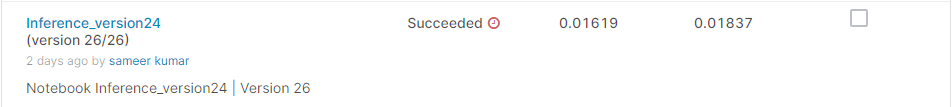